### <span style="color:green">Проведем RFM анализ клиентов для ответа на следующие вопросы:</span>

1. Какое максимальное количество покупок было совершено одним пользователем?
2. Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)
3. Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?
4. Какая верхняя граница у количества покупок у пользователей с классом 2 в подсегменте R?
5. Сколько пользователей попало в сегмент 111?
6. Сколько пользователей попало в сегмент 311?
7. В каком RFM-сегменте самое большое кол-во пользователей?
8. В каком RFM-сегменте самое маленькое кол-во пользователей?
9. Какое количество пользователей попало в самый малочисленный сегмент?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загрузим данные с конвертацией нужных полей в строку.
df = pd.read_csv('RFM_ht_data.csv', dtype={"CustomerCode": str})

In [3]:
df.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [4]:
# Проверим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     332730 non-null  object 
 1   CustomerCode  332730 non-null  object 
 2   InvoiceDate   332730 non-null  object 
 3   Amount        332730 non-null  float64
dtypes: float64(1), object(3)
memory usage: 10.2+ MB


In [5]:
lst_id = df.CustomerCode.unique().tolist()

In [6]:
# Проверим значения CustomerCode на наличие ошибок
import re

def non_numeric(id):
    pattern = r"\D"
    if re.search(pattern, id):
        return True
    else:
        return False

selected_ids = [id for id in lst_id if non_numeric(id)]

print(selected_ids)

['7323D00214002056', '13131848 ', '7323d00214002056', '18039109 ', '13142992 ']


In [7]:
# Уберем пробелы в значениях для корректного показания данных
df['CustomerCode'] = df.CustomerCode.apply(lambda x: x.strip())

In [8]:
# Приведем все буквенные значения к верхнему регистру, чтобы исключить разделение id
df['CustomerCode'] = df['CustomerCode'].str.upper()

In [9]:
# Перевведем столбец InvoiceDate в формат даты
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
df.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [11]:
# Посмотрим общее описание колонки InvoiceDate
df['InvoiceDate'].describe(datetime_is_numeric=True)

count                           332730
mean     2020-09-15 16:35:03.846361856
min                2020-09-01 00:00:00
25%                2020-09-08 00:00:00
50%                2020-09-16 00:00:00
75%                2020-09-24 00:00:00
max                2020-09-30 00:00:00
Name: InvoiceDate, dtype: object

In [12]:
# Определим последнюю дату, от которой будем считать разницу дат
last_date = df['InvoiceDate'].max()

In [13]:
# Делаем RFM таблицу на основе наших данных
rfmTable = df.groupby('CustomerCode', as_index=False).agg({'InvoiceDate': lambda x: (last_date - x.max()).days,
                                                           'InvoiceNo': lambda x: len(x), 
                                                           'Amount': lambda x: x.sum()})

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary'}, inplace=True)

In [14]:
# Проверим не потеряли ли мы значения в таблице
rfmTable.shape[0], df.CustomerCode.nunique()

(123729, 123729)

In [15]:
# Определяем квантили для нашей таблицы
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])
quantiles

/var/folders/m6/gnxqn1753_g808tzdcqqmdq80000gn/T/ipykernel_12074/578525064.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])


,recency,frequency,monetary
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.66
0.75,16.0,3.0,4008.96


In [16]:
rfm_segmentation = rfmTable

In [17]:
# Делаем функцию для Recency сегмента
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4

# Делаем функцию для Frequency и Monetary сегментов 
def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [18]:
# Применяем нашу сегментацию
rfm_segmentation['R_Quartile'] = rfm_segmentation['recency'].apply(RClass, args=('recency',quantiles))
rfm_segmentation['F_Quartile'] = rfm_segmentation['frequency'].apply(FMClass, args=('frequency',quantiles))
rfm_segmentation['M_Quartile'] = rfm_segmentation['monetary'].apply(FMClass, args=('monetary',quantiles))

# Создаем сегменты
rfm_segmentation['RFMClass'] = (rfm_segmentation.R_Quartile.map(str)
                                + rfm_segmentation.F_Quartile.map(str)
                                + rfm_segmentation.M_Quartile.map(str))

In [19]:
# crosstab для F и R сегментов
pd.crosstab(index=rfm_segmentation.R_Quartile, columns=rfm_segmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,14434,4670,5795,6073
2,9634,5890,8632,10398
3,3091,3748,7734,13263
4,542,1311,5415,23099


In [20]:
# графика в формате SVG более четкая и разборчивая
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'viridis'

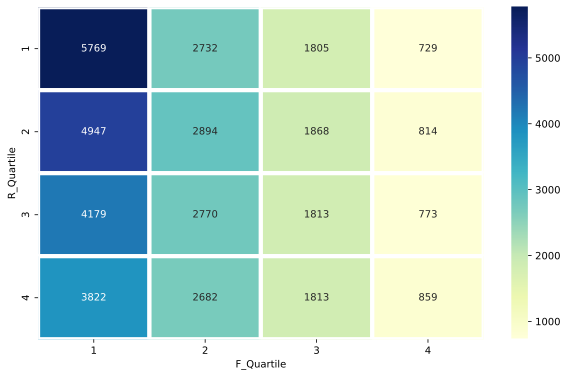

In [21]:
# Построим heatmap для рассматрения медианного значения LTV в сегменте
viz = rfm_segmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary', 
                        aggfunc=np.median).applymap(int)

sns.heatmap(viz, cmap="YlGnBu",
            annot=True,
            fmt=".0f",
            linewidths=4.15,
            annot_kws={"size": 10},
            xticklabels=1,
            yticklabels=1);

<span style="color:SteelBlue">**1. Какое максимальное количество покупок было совершено одним пользователем?**</span>

In [22]:
rfmTable.frequency.max()

204

<span style="color:SteelBlue">**2. Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)**</span>

In [23]:
quantiles['monetary'].values[0]

765.0

<span style="color:SteelBlue">**3. Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?**</span>

In [24]:
quantiles

,recency,frequency,monetary
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.66
0.75,16.0,3.0,4008.96


In [25]:
rfmTable.query('frequency > 3').sort_values('frequency').frequency.head(1).values[0]

4

<span style="color:SteelBlue">**4. Какая верхняя граница у количества покупок у пользователей с классом 2 в подсегменте R?**</span>

In [26]:
rfm_segmentation.query('R_Quartile == 2').sort_values('recency', ascending=False).head(1).recency.max()

8

<span style="color:SteelBlue">**5. Сколько пользователей попало в сегмент 111?**</span>

In [27]:
rfm_segmentation[rfm_segmentation['RFMClass'] == '111'].shape[0]

9705

<span style="color:SteelBlue">**6. Сколько пользователей попало в сегмент 311?**</span>

In [28]:
rfm_segmentation[rfm_segmentation['RFMClass'] == '311'].shape[0]

1609

<span style="color:SteelBlue">**7. В каком RFM-сегменте самое большое кол-во пользователей?**</span>

In [29]:
(
    rfm_segmentation.groupby('RFMClass', as_index=False)
                    .agg({'CustomerCode': 'count'})
                    .sort_values('CustomerCode', ascending=False)
                    .RFMClass.values[0]
)

'444'

<span style="color:SteelBlue">**8. В каком RFM-сегменте самое маленькое кол-во пользователей?**</span>

In [30]:
(
    rfm_segmentation.groupby('RFMClass', as_index=False)
                    .agg({'CustomerCode': 'count'})
                    .sort_values('CustomerCode')
                    .RFMClass.values[0]
)

'414'

<span style="color:SteelBlue">**9. Какое количество пользователей попало в самый малочисленный сегмент?**</span>

In [31]:
(
    rfm_segmentation.groupby('RFMClass', as_index=False)
                    .agg({'CustomerCode': 'count'})
                    .sort_values('CustomerCode')
                    .CustomerCode.values[0]
)

2